# Data Driven Approaches

In this tutorial we want to explore some data driven methods for image reconstruction. We will consider the limited angle CT problem with additonal noise on the sinogram. Our test data will be composed of simple shapes which can be loaded from the utils module.

Let's take a first look at some of the shapes.

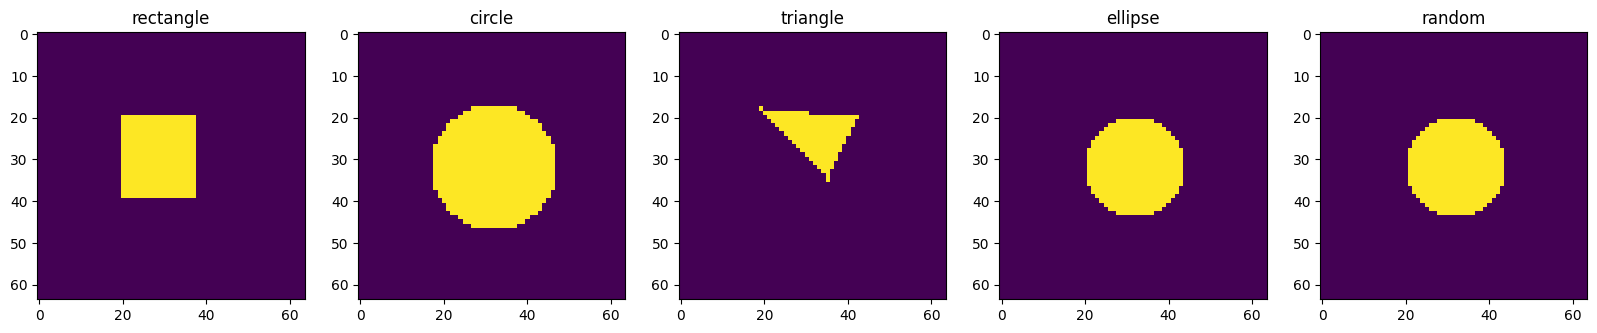

In [1]:
import matplotlib.pyplot as plt
from utils import shapes

img_size = 64 #image size
S = shapes(img_size=img_size, noise_lvl=0.05) # the shape class
shape_names = ['rectangle', 'circle', 'triangle', 'ellipse', 'random'] # all shape names

# plot all shapes
fig, ax = plt.subplots(1,len(shape_names), figsize=(20,15))
for i in range(len(shape_names)):
    ax[i].imshow(S.get_shape(shape_names[i]))
    ax[i].set_title(shape_names[i])

# How does our data look like?
Our data is given as the naive recon of a limited angle CT problem. The next cell defines the function that samples a batch of the data. The second output of the function ```get_data``` is the original input (ground truth) that will be used for the supervised learning scheme.

The original image is returned as a  ```torch``` tensor, since this is more convinient for the training later. Furthermore, inputs and outputs into the net will have the shape

$$
B \times C \times N\times N
$$

where

* $B$ denotes the batch size,
* $C$ the number of channels (we always use $C=1$),
* $N$ the image dimension.

We have to be careful when we compare ```numpy``` and ```torch``` obejcts in the following. If we want to plot a ```torch``` Tensor ```x```, the following steps might be necessary:

* ```x.detach()```: if the tensor ```x``` has a gradient, then we need to detach it first.
* ```x.numpy()```: this converts a ```torch``` tensor without a gradient, to a ```numpy``` array. Commands like ```plt.imshow``` do this internally.
* ```x[b,c,...]```: ```plt.imshow``` only works for 2D arrays, so we have to select one batch element $b$ and a channel $c$.

We now define a routine that returns our data. Basically, we sample a shape $x$ and then also return

$$R^{-1}(R(x) + \delta)$$

as the input to the net, where $R$ is the Radon transform with limited angles ($0^\circ$ to $90^\circ$), and $\delta$ denotes noise. Here, $R^{-1}$ is not the true inverse, but the naive Radon inversion.

In [2]:
import torch
import numpy as np
from operators import Radon

num_thetas = 10
min_angle = 0
max_angle = 90
theta = np.linspace(min_angle, max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

def get_data(batch_size, train_shape, noise_lvl):
    x_recon = np.zeros((batch_size, 1, img_size, img_size))
    x = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        x[i,0,...] = S.get_shape(train_shape)
        sinogram =  R(x[i,0,...])
        sinogram += np.random.normal(0, noise_lvl, size=sinogram.shape)
        x_recon[i, 0, ...] = R.inverse(sinogram)

    return x_recon, torch.Tensor(x)

# Let's look at our Data!
The below cell samples data from ```get_data```.

Text(0.5, 1.0, 'Original')

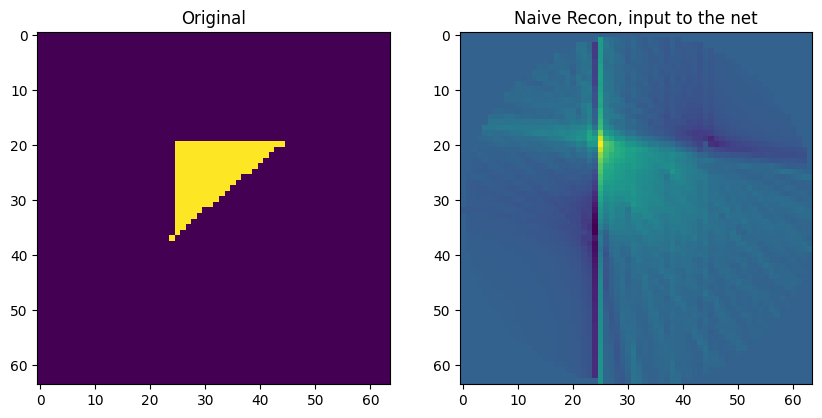

In [10]:
x_recon, x = get_data(5, 'random', 0.00)

fig, ax = plt.subplots(1,2, figsize = (10,8))
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon, input to the net')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

# Loading the model

We now define the neural network model, we want to train in the following. Here, we use the celebrated UNet structure from this paper:

<center>
*Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18 (pp. 234-241). Springer International Publishing.*
</center>


The model architecture is reimplemented (and slightly compressed) in the ```models``` module. We will now load the model and check how many parameters we will train in the following. 

**Spoiler**: Quite a lot.

In [11]:
from models import UNet
model = UNet()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])

print('Loaded the model with ' +str(num_params) + ' trainable parameters')

Loaded the model with 7696193 trainable parameters


# Training the model
In order to train the model we consider the following minization problem:

$$
\min_\theta \mathbb{E}_{(x,y)}\left[ \ell(f_\theta(x), y)\right]$$

where

* $\theta$ denote the parameter of the neural network $f_\theta$,
* $x$ is the noisy, badly recosntructed input,
* $y$ is the clean ground truth image,
* $\ell$ is the $L^2$ distance, i.e., $\ell(\hat y, y) = \|\hat y - y\|^2$.

In order to solve can use stoachstic Gradient Descent, which yields the update

$$\theta \gets \theta - \alpha \ \nabla_\theta \left(\sum_{i=1}^B \ell(f_\theta(x_i), y_i)\right).$$

Here, $B$ denotes the batch size and $(x_1,y_1),\ldots, (x_B,y_B)$ are the outputs of ```get_data``` in each step. The parameter $\alpha$ denotes the step size.

Alternatively, we employ the ADAM optimizer, which we define in the following cell. Additonally we define a learning rate scheduler.

In [13]:
import torch.nn as nn

loss_fct = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)

## The train step

We now define the train step, that updates the varaibels $\theta$.

In [16]:
def train_step(get_data, batch_size=5, train_shape='rectangle', noise_lvl=0.01):
    opt.zero_grad() # zero out gradients from previous step
    
    x_recon, x = get_data(batch_size, train_shape, noise_lvl) # get data
    x_model = model(x_recon) # compute the model
    loss = loss_fct(x_model, x) # compute the loss
    loss.backward() # compute the gradients
    opt.step() # make a step of the optimizer
    scheduler.step() # make a scheduler step

    # additonal computations and plotting
    loss1 = loss.item()
    loss2 = loss_fct(torch.Tensor(x_recon), torch.Tensor(x)).item()

    print(30*'-')
    print('Epoch: ' + str(epoch))
    print('Current Loss:' + str(loss1))
    print('IRadon Loss:' + str(loss2))
    for param_group in opt.param_groups:
        print('Current lr:' + str(param_group['lr']))

## Execute the training
We can now specifiy the trainin process and then run it :)

In [17]:
train_shape = 'circle'
batch_size = 5
epochs = 400
noise_lvl = 0.02

for epoch in range(epochs):
    train_step(get_data, batch_size=batch_size, train_shape=train_shape, noise_lvl = noise_lvl)

------------------------------
Epoch: 0
Current Loss:0.09798581898212433
IRadon Loss:0.15134242177009583
Current lr:0.0009045084971874736
------------------------------
Epoch: 1
Current Loss:0.07988714426755905
IRadon Loss:0.15973028540611267
Current lr:0.0007938926261462366
------------------------------
Epoch: 2
Current Loss:0.12447420507669449
IRadon Loss:0.15448734164237976
Current lr:0.0006545084971874737
------------------------------
Epoch: 3
Current Loss:0.05515294149518013
IRadon Loss:0.15124228596687317
Current lr:0.0005
------------------------------
Epoch: 4
Current Loss:0.06308910995721817
IRadon Loss:0.15925022959709167
Current lr:0.00034549150281252633
------------------------------
Epoch: 5
Current Loss:0.06689978390932083
IRadon Loss:0.16170142590999603
Current lr:0.0002061073738537635
------------------------------
Epoch: 6
Current Loss:0.06752987205982208
IRadon Loss:0.16208793222904205
Current lr:9.549150281252634e-05
------------------------------
Epoch: 7
Current 

# Saving and loading the models
If you want you can save or load models with the functions below.

**BE CAREFUL NOT TO OVERWRITE PRECIOUS MODELS**

In [ ]:
## save the model
save_model = False
if save_model:
    torch.save(model.state_dict(), train_shape + '.pt')

In [132]:
load_model = False
if load_model:
    model.load_state_dict(torch.load('circle.pt'))

# The Results

In the following cell, we test how good the performance is :)

In [133]:
# %% Test
from utils import get_phantom
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

img_size_test=64
S_test = shapes(img_size=img_size_test)

def plot_result(idx, noise_lvl, min_angle, max_angle):
    theta = np.linspace(min_angle,max_angle, endpoint = False, num=num_thetas)
    R = Radon(theta=theta)
    if idx < 4:
        x = S_test.get_shape(S.shape_names[idx])
    else:
        x = get_phantom(img_size_test)
    
    sinogram = R(x)
    sinogram += np.random.normal(0, noise_lvl, size=sinogram.shape)
    x_recon = R.inv(sinogram)
    x_model = model(x_recon).detach().numpy()[0,0,...]
    
    fig, ax = plt.subplots(1,3, figsize = (20,15))
    ax[0].imshow(x)
    ax[1].imshow(x_model)
    ax[1].set_title('Network Recon, error: ' +str(np.linalg.norm(x-x_model)))
    ax[2].imshow(x_recon)
    ax[2].set_title('Naive Recon, error: ' +str(np.linalg.norm(x-x_recon)))

idx_toggle = widgets.ToggleButtons(
    options=[('rectangle',0), ('circle',1), ('triangle',2), ('ellipse',3), ('phantom', 4)],
    description='Test Shapes',
    disabled=False
)
a_min_slider = widgets.FloatSlider(min = 0, max = 90, step = 10, value = 0, continuous_update = False)
a_max_slider = widgets.FloatSlider(min = 90, max = 180, step = 10, value = 0, continuous_update = False)
n_slider = widgets.FloatSlider(min = 0.0, max = .03, step = 0.001, value = 0.01, continuous_update = False)

interactive_plot = interactive(plot_result,idx = idx_toggle, min_angle=a_min_slider, max_angle=a_max_slider, noise_lvl=n_slider)
display(interactive_plot)

interactive(children=(ToggleButtons(description='Test Shapes', options=(('rectangle', 0), ('circle', 1), ('tri…

# How can we combine model and data driven approaches?

A popular way to combine model and data driven approaches are so-called plug-and-play (PnP) methods. The starting point is a variational minization problem

$$\min_x \frac{1}{2}\, \|Ax - y\|^2 + \lambda J.$$

These problem can be solved via prox-based methods, for example an ADMM update scheme

$$
\begin{align*}
x &\gets \operatorname*{arg min}_{x}\ \frac{1}{2}\, \|Ax - y\|^2 + \frac{\rho}{2} \|{v - u}\|^2,\\
v &\gets \operatorname*{arg min}_{v}\ \lambda J(v) + \frac{\rho}{2} \|{v - (x + u)}\|^2,\\
u &\gets u + x - v.
\end{align*}
$$

Here, the first line can be solved can be solved with a linear solver (e.g. the cg iteration) and the last line ist explicit. The second line is in fact the prox operator of $J$ since 

$$\operatorname{prox}_{\lambda/\rho\ J}(x+u) =  \operatorname*{arg min}_{v}\ \lambda J(v) + \frac{\rho}{2} \|{v - (x + u)}\|^2.$$

Evaluating this prox can be complicated and relies on a possibly hand-crafted functional $J$. The idea of PnP methods consists of replacing a prox step of this kind by an arbitratry map $D$. I.e. the iteration takes the form

$$
\begin{align*}
x &\gets \operatorname*{arg min}_{x}\ \frac{1}{2}\, \|Ax - y\|^2 + \frac{\rho}{2} \|{v - u}\|^2,\\
v &\gets D_\lambda(x + u),\\
u &\gets u + x - v.
\end{align*}
$$

Typically this function $D$ is a simple denoiser, i.e., a mapping that takes a noisy images and outputs a clear version.

## Training the denoiser

We want to try these PnP approaches a


We now train a network on a simple denoising task

In [93]:
noise_lvl = 0.01

def get_data(batch_size, train_shape, noise_lvl):
    x_recon = np.zeros((batch_size, 1, img_size, img_size))
    x = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        x[i,0,...] = S.get_shape(train_shape)
        x_recon[i, 0, ...] = x[i,0,...] + np.random.normal(0, noise_lvl, size=x[i,0,...].shape)
    return x_recon, torch.Tensor(x)

# Look at the data again

The data looks slightly different now.

Text(0.5, 1.0, 'Original')

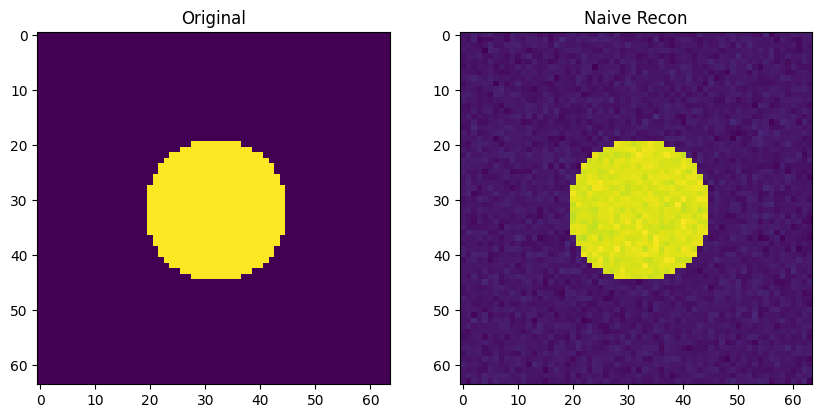

In [101]:
x_recon, x = get_data(5, 'random', 0.02)

fig, ax = plt.subplots(1,2, figsize = (10,8))
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

# Train again

With the same set up as before we now train another model. We redifine the necessary objects.

In [102]:
model = UNet()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)

In [103]:
train_shape = 'random'
batch_size = 5
epochs = 50

for epoch in range(epochs):
    train_step(get_data, batch_size=batch_size, train_shape=train_shape)

------------------------------
Epoch: 0
Current Loss:0.10374482721090317
IRadon Loss:9.946025966200978e-05
Current lr:0.0009755282581475768
------------------------------
Epoch: 1
Current Loss:0.0881713330745697
IRadon Loss:0.0001005643280223012
Current lr:0.0009045084971874736
------------------------------
Epoch: 2
Current Loss:0.04264938086271286
IRadon Loss:0.00010141987877432257
Current lr:0.0007938926261462366
------------------------------
Epoch: 3
Current Loss:0.08085910975933075
IRadon Loss:9.85884471447207e-05
Current lr:0.0006545084971874737
------------------------------
Epoch: 4
Current Loss:0.03862887993454933
IRadon Loss:9.988886449718848e-05
Current lr:0.0005
------------------------------
Epoch: 5
Current Loss:0.030301770195364952
IRadon Loss:0.00010102785745402798
Current lr:0.00034549150281252633
------------------------------
Epoch: 6
Current Loss:0.019490517675876617
IRadon Loss:9.97281531454064e-05
Current lr:0.0002061073738537635
------------------------------
Ep

# How well does it work?

Text(0.5, 1.0, 'Original')

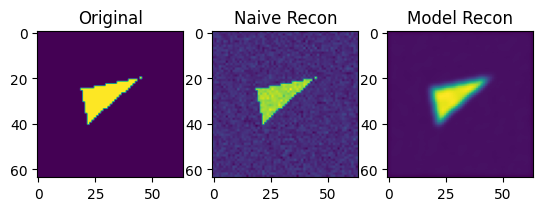

In [113]:
x_recon, x = get_data(5, 'random', 0.05)

fig, ax = plt.subplots(1,3)
ax[2].imshow(model(x_recon).detach()[0,0,...])
ax[2].set_title('Model Recon')
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

In [129]:
from optimizers import admm

def model_prox(x, lamda):
    lamda = max(min(lamda, 1.),0)
    return (1-lamda) * x + lamda * model(x).detach().numpy()[0,0,...]

num_thetas = 30
min_angle = 0
max_angle = 180
theta = np.linspace(min_angle, max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

def plot_recon(noise_lvl):
    x_recon, x = get_data(5, 'random', 0.01)
    Rx = R(x[0,0,...])
    Rx += np.random.normal(0, noise_lvl, size=Rx.shape)
    x0 = R.inv(Rx)
    sinogram = R(x0)
    
    pnpadmm = admm(R, 0*x0, Rx, rho=0.4, lamda=1., verbosity=0, prox=model_prox, max_it=35, max_inner_it=1)
    pnpadmm.solve()
    
    x = x[0,0,...].numpy()
    x_model = model(x0).detach().numpy()[0,0,...]
    fig, ax = plt.subplots(1,4, figsize=(20,15))
    ax[0].imshow(x)
    ax[0].set_title('original')
    ax[2].imshow(pnpadmm.x)
    ax[2].set_title('PnP ADMM Recon, error: ' + str(np.linalg.norm(pnpadmm.x - x)))
    ax[1].imshow(x_model)
    ax[1].set_title('Network Recon, error: ' + str(np.linalg.norm(x_model - x)))
    ax[3].imshow(x0)
    ax[3].set_title('Naive Recon')



n_slider = widgets.FloatSlider(min = 0.0, max = .1, step = 0.001, value = 0.01, continuous_update = False)
interactive_plot = interactive(plot_recon, noise_lvl=n_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='noise_lvl', max=0.1, step=…